In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [11]:
df = pd.read_csv("loan_data.csv")

In [13]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [15]:
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

There are no missing values in the dataset.

In [18]:
df.fillna({
    'person_age': df['person_age'].median(),
    'person_income': df['person_income'].median(),
    'person_emp_exp': df['person_emp_exp'].median(),
    'loan_amnt': df['loan_amnt'].median(),
    'loan_int_rate': df['loan_int_rate'].mean(),
    'loan_percent_income': df['loan_percent_income'].median(),
    'credit_score': df['credit_score'].median()
}, inplace=True)

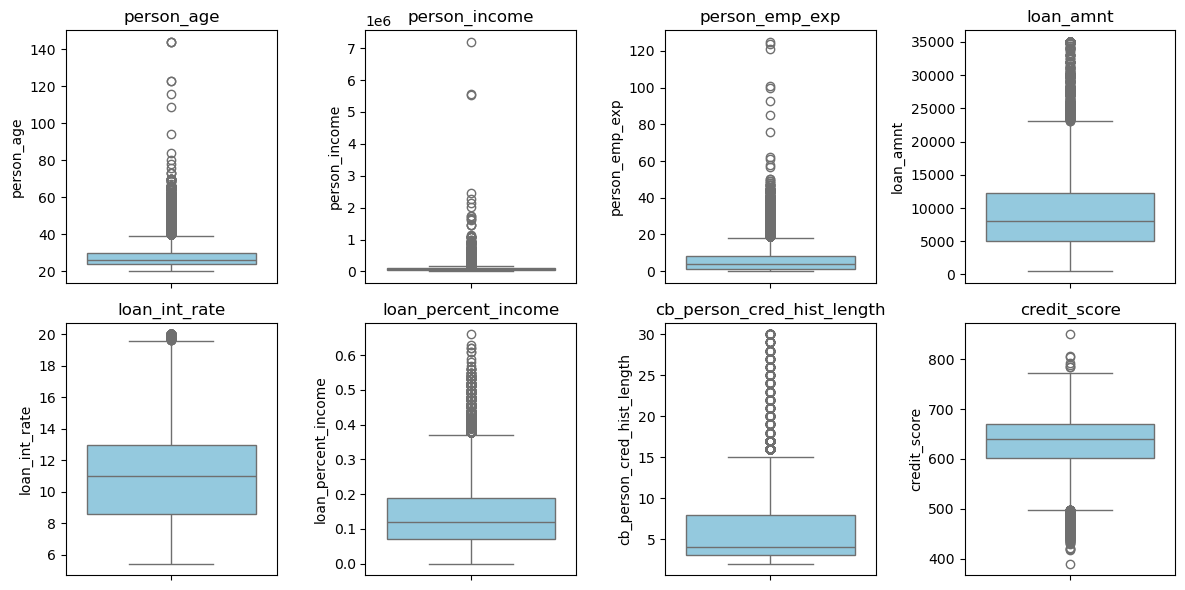

In [21]:
num_cols = ["person_age", "person_income", "person_emp_exp", "loan_amnt", 
            "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", 
            "credit_score"]

plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)  # Create a grid of 2 rows, 4 columns
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(col)

plt.tight_layout()
plt.show()


In [22]:
pip install pyod

Note: you may need to restart the kernel to use updated packages.


In [23]:
from pyod.models.knn import KNN

In [35]:

knn = KNN(contamination=0.09)  
knn.fit(df[num_cols])


outlier_pred = knn.predict(df[num_cols])


df_cleaned = df[outlier_pred == 0]
print(f"Original data size: {df.shape[0]}, Cleaned data size: {df_cleaned.shape[0]}")


IQR_FACTOR = 1.5  

Q1 = df_cleaned[num_cols].quantile(0.25)
Q3 = df_cleaned[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - IQR_FACTOR * IQR
upper_bound = Q3 + IQR_FACTOR * IQR

df_cleaned = df_cleaned[~((df_cleaned[num_cols] < lower_bound) | (df_cleaned[num_cols] > upper_bound)).any(axis=1)]

print("Data Shape After More Strict IQR Removal:", df_cleaned.shape)

Original data size: 45000, Cleaned data size: 41710
Data Shape After More Strict IQR Removal: (35797, 14)


In [37]:
num_cols = ["person_age", "person_income", "person_emp_exp", "loan_amnt", 
            "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", 
            "credit_score"]

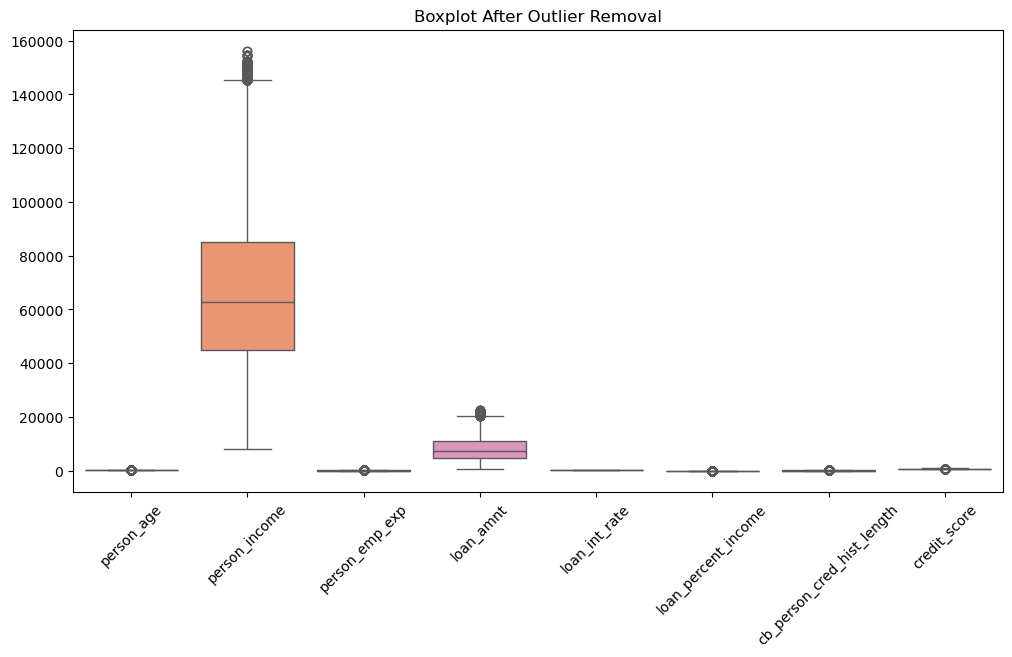

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[num_cols], palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplot After Outlier Removal")
plt.show()


In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_cols]) 
df_scaled = pd.DataFrame(df_scaled, columns=num_cols) 
cat_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

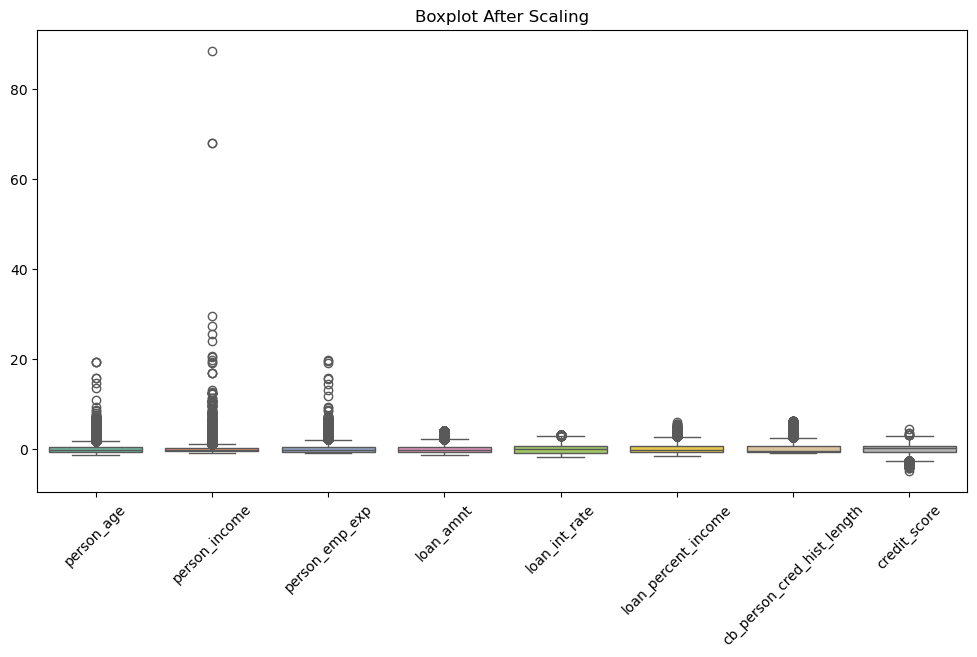

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled[num_cols], palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplot After Scaling")
plt.show()

In [47]:
X = df_cleaned.drop(columns=['loan_status'])  # Features
y = df_cleaned['loan_status']  # Target variable

# Convert categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

# **Step 6: Apply SMOTE for Imbalanced Data Handling**
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# **Step 7: Split Data for Training & Testing**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [48]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Awan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Accuracy: 0.8904
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      5645
           1       0.87      0.92      0.89      5645

    accuracy                           0.89     11290
   macro avg       0.89      0.89      0.89     11290
weighted avg       0.89      0.89      0.89     11290



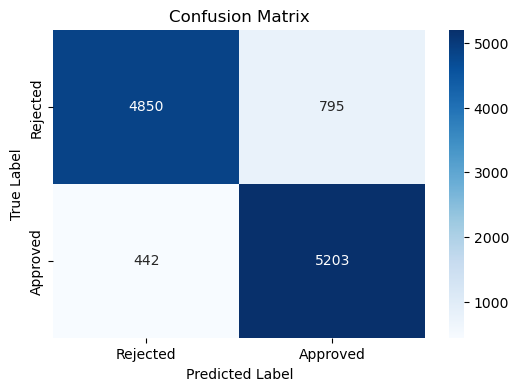

In [53]:
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

# **Step 10: Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()